# Pierce County Jail Records

This notebook analyzes inmate booking and release records disclosed by Pierce County Corrections. The records include all inmates released from Pierce County Jail from October 1, 2016 to July 31, 2018.

## Prior data cleaning tasks

### setup/
- create unique booking_id_hash for each booking_id
- merge booking, release disposition, and place of birth records
- mask for immigration hold status, release to immigration
- clean birthplace values and mask for birth in US
- create unique hash_id for each record
- predict race categories using ethnicolr module (FL census data)
- identify disposition of last charge released for each booking

### charges/
- merge hand-coded charge type, category, and seriousness levels for each record
- drop unknown charges
- drop records with max charge type 'other' (no criminal charges?)
    - we lose 16 cases of immgiration holds, including several where hold is only charge
    - three cases with immigration holds have 'probat hold' as only other charge. ICE-probation link?
    - this category includes lots of other olds, community custody jail. many have crime listed in booking charge txt but hard to know what this means?
    - if we drop these, does this skew impact of our seriousness variable? since max charge type 'other' == max seriousness 0?
- count number of charges with associated cause_num; topcount to maximum of 10 charges

### bail/
- merge records of bail payment
- calculate total fine paid
- drop personally-identifiable information (booking ID, name, date of birth)


## Caveats

- Charges were released to us as un-standardized descriptions; we searched for each charge in the WA RCW to assign charge type, category, and seriousness rank. This required independent research and may introduce errors. Where  seriousness is ambiguous we have "rounded up" to most serious possible charge.
- Only analyzing cases marked explicitly as an immigration hold; 18 cases with miscellaneous holds may also be immigration holds. We analyzed impact of all holds on jail time and found it to be less significant than impact of immigration hold.
- We only have records of bail paid, not bail set for each charge.

In [1]:
import sys
import pandas as pd
import numpy as np
from datetime import datetime

import itertools
from itertools import chain, combinations

import statsmodels.formula.api as smf
import scipy.stats as scipystats
import statsmodels.api as sm
import statsmodels.stats.stattools as stools
import statsmodels.stats as stats
from statsmodels.graphics.regressionplots import *

import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import seaborn as sns

%matplotlib inline
plt.rcParams['figure.figsize'] = (8, 6)

import copy
import math
import time

In [2]:
print(pd.__version__)

0.23.4


In [3]:
print(sys.version)

3.7.1 (default, Dec 14 2018, 13:28:58) 
[Clang 4.0.1 (tags/RELEASE_401/final)]


In [4]:
# pd.set_option('display.float_format', lambda x: '%.2f' % x)

# Load data

In [5]:
path = '../input/'

In [6]:
df = pd.read_csv(f'{path}pierce.csv.gz', sep='|', compression='gzip', low_memory=False)

In [7]:
df.head(2)

,booking_id,booking_dt,release_dt,booking_charge_desc,booking_charge_txt,charge_release_dt,title_txt,cause_num,jurisdiction_cd,release_disposition_desc,...,drug,other,property,public_order,sex,violent,felony,misdemeanor,total_fine,paid_bail
0,0005bb13ca0607809ca8daba16db7724def2fd3d,2017-11-21 22:05:00,2017-11-22 16:00:00,"FEL HARASS-DV, DV-THREATS/DEATH THRT",NaN,2017-11-22 20:00:00,"Report Criteria: 10/01/2017 to 07/31/2018, Dis...",17-1-04484-1,SUP,PR,...,0,0,0,0,0,1,1,0,0.0,False
1,000604f6650702576e851852fe84984d6097b8bc,2017-12-02 18:26:00,2018-07-11 16:03:00,ASLT 3,NaN,2018-07-11 22:00:00,"Report Criteria: 10/01/2017 to 07/31/2018, Dis...",17-1-04595-2,SUP,Time Served,...,0,0,0,0,0,1,1,0,0.0,False


In [8]:
df.tail(2)

,booking_id,booking_dt,release_dt,booking_charge_desc,booking_charge_txt,charge_release_dt,title_txt,cause_num,jurisdiction_cd,release_disposition_desc,...,drug,other,property,public_order,sex,violent,felony,misdemeanor,total_fine,paid_bail
71008,fffc7feb8fb5516b10135b0930b5bc823aebbfb0,2017-03-02 16:34:00,2017-04-29 05:00:00,RECK ENDANGER,NaN,2017-04-29 05:00:00,"Report Criteria: 10/01/2016 to 09/30/2017, Dis...",16-1-03631-9,SUP,Time Served,...,0,0,0,1,0,0,0,1,0.0,False
71009,fffc8064aa94fda4ec4226979f12acca416dc79a,2016-10-19 06:33:00,2016-10-20 18:49:00,ASSAULT 4 /DV,NaN,2016-10-20 22:00:00,"Report Criteria: 10/01/2016 to 09/30/2017, Dis...",6ZC002680,PD1,Court Order,...,0,0,0,0,0,1,1,0,0.0,False


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71010 entries, 0 to 71009
Data columns (total 50 columns):
booking_id                  71010 non-null object
booking_dt                  71010 non-null object
release_dt                  71010 non-null object
booking_charge_desc         71010 non-null object
booking_charge_txt          4686 non-null object
charge_release_dt           71010 non-null object
title_txt                   71010 non-null object
cause_num                   55200 non-null object
jurisdiction_cd             71010 non-null object
release_disposition_desc    71010 non-null object
post_flg                    71010 non-null object
gender_desc                 71010 non-null object
race_desc                   71010 non-null object
hash_id                     71010 non-null object
amer_indian_alaskan         71010 non-null int64
asian_pacific_island        71010 non-null int64
black                       71010 non-null int64
hispanic                    71010 non-null in

In [10]:
df['race_desc'] = df['race_desc'].str.lower()
df['gender_desc'] = df['gender_desc'].str.lower()
df['booking_dt'] = pd.to_datetime(df['booking_dt'])
df['release_dt'] = pd.to_datetime(df['release_dt'])
df['charge_release_dt'] = pd.to_datetime(df['charge_release_dt'])

In [11]:
total_records = len(df)
unique_booking_ids = len(set(df.booking_id))
print(f'{total_records} total records.')
print(f'{unique_booking_ids} unique booking IDs.')

71010 total records.
29313 unique booking IDs.


### Top release dispositions:

For cases with immigration holds:

In [12]:
hold_mask = df['imm_hold'] == 1

In [13]:
pr = df['release_disposition_desc'] == 'PR'

In [14]:
(df[hold_mask]['release_disposition_desc'].value_counts() / len(df[hold_mask]) * 100).head(10)

Immigration               18.290855
Dismissed                 13.193403
WSI Chain                 13.043478
Credit for Time Served     8.695652
Mini-Chain                 7.196402
Time Served                6.596702
Court Order                5.097451
NCF Final                  4.947526
PR                         4.797601
NCF, Pending Inv           3.598201
Name: release_disposition_desc, dtype: float64

For cases without immigration hold:

In [15]:
(df[~hold_mask]['release_disposition_desc'].value_counts() / len(df[~hold_mask]) * 100).head()

Bail Bond      14.253017
PR             11.065778
Time Served     9.851727
Dismissed       8.346246
WSI Chain       7.906970
Name: release_disposition_desc, dtype: float64

In [16]:
sum(df.loc[hold_mask]['release_disposition_desc'] == 'PR') / len(df[hold_mask])

0.047976011994003

In [17]:
sum(df.loc[~hold_mask]['release_disposition_desc'] == 'PR') / len(df[~hold_mask])

0.1106577768932232

# Drop duplicates

Subsequent cell drops duplicate booking IDs so count = individual bookings, not charges. All variables we are analyzing have been masked at booking level so it doesn't matter which individual record we retain for each set of booking charges.

In [18]:
df_all = df.copy()
df = df.drop_duplicates(subset=['booking_id'])
assert len(df) == len(set(df_all['booking_id']))

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29313 entries, 0 to 71009
Data columns (total 50 columns):
booking_id                  29313 non-null object
booking_dt                  29313 non-null datetime64[ns]
release_dt                  29313 non-null datetime64[ns]
booking_charge_desc         29313 non-null object
booking_charge_txt          1908 non-null object
charge_release_dt           29313 non-null datetime64[ns]
title_txt                   29313 non-null object
cause_num                   21547 non-null object
jurisdiction_cd             29313 non-null object
release_disposition_desc    29313 non-null object
post_flg                    29313 non-null object
gender_desc                 29313 non-null object
race_desc                   29313 non-null object
hash_id                     29313 non-null object
amer_indian_alaskan         29313 non-null int64
asian_pacific_island        29313 non-null int64
black                       29313 non-null int64
hispanic             

In [20]:
df.set_index('booking_id',inplace=True)

In [21]:
hold_mask = df['imm_hold'] == 1

## General measures

### Date ranges

In [22]:
earliest_booking = df.booking_dt.min()
latest_booking = df.booking_dt.max()
earliest_release = df.release_dt.min()
latest_release = df.release_dt.max()
print(f'Booking dates:\n{df.booking_dt.describe()}\n\nRelease dates:\n{df.release_dt.describe()}')

Booking dates:
count                   29313
unique                  29174
top       2016-10-05 18:23:00
freq                        2
first     2013-06-21 18:42:00
last      2018-07-31 15:38:00
Name: booking_dt, dtype: object

Release dates:
count                   29313
unique                  15220
top       2018-03-29 09:00:00
freq                       26
first     2016-10-01 01:00:00
last      2018-07-31 21:55:00
Name: release_dt, dtype: object


In [23]:
f'{earliest_release.month_name()} {earliest_release.year}'

'October 2016'

In [24]:
earliest_release.month_name()

'October'

In [25]:
earliest_booking.year

2013

### Demographics

Demographics as reported by Pierce County corrections:

In [26]:
race_count = df['race_desc'].value_counts()
race_percent = race_count/len(df)*100
print(f'Count of race categories:\n{race_count}\n')
print(f'Race categories as percent of total jail population:\n{race_percent}')

Count of race categories:
white                   16919
black                    7110
hispanic                 2540
asian/pacific island     1790
amer indian/alaskan       892
unknown                    62
Name: race_desc, dtype: int64

Race categories as percent of total jail population:
white                   57.718418
black                   24.255450
hispanic                 8.665097
asian/pacific island     6.106506
amer indian/alaskan      3.043018
unknown                  0.211510
Name: race_desc, dtype: float64


In [27]:
hold_race_count = df[hold_mask]['race_desc'].value_counts()
hold_race_percent = hold_race_count/len(df[hold_mask])*100
print(f'Count of race categories with hold:\n{hold_race_count}\n')
print(f'Race categories as percent of holds:\n{hold_race_percent}')

Count of race categories with hold:
hispanic                152
asian/pacific island     18
white                     9
black                     8
unknown                   1
Name: race_desc, dtype: int64

Race categories as percent of holds:
hispanic                80.851064
asian/pacific island     9.574468
white                    4.787234
black                    4.255319
unknown                  0.531915
Name: race_desc, dtype: float64


In [28]:
len(df[hold_mask]) / len(df) * 100

0.6413536656091153

In [29]:
float(hold_race_percent['hispanic'])

80.85106382978722

### Gender:

In [30]:
value_count = df['gender_desc'].value_counts()
print(f'Count of gender categories:\n{value_count}\n')
print(f'Gender categories as percent of total jail population:\n{value_count/len(df)*100}')

Count of gender categories:
male      22029
female     7284
Name: gender_desc, dtype: int64

Gender categories as percent of total jail population:
male      75.150957
female    24.849043
Name: gender_desc, dtype: float64


## Statistics on inmates with immigration holds

In [31]:
race_ice_holds = df.groupby('race_desc')['imm_hold'].sum()
n = df['race_desc'].value_counts()
race_percent = n / len(df) * 100
race_hold_df = pd.DataFrame([n, race_percent, race_ice_holds]).T
cols = ['N',
        'Race category as % of total',
        'Bookings with ICE detainers']
race_hold_df.columns = cols
race_hold_df.reset_index(inplace=True)
race_hold_df = race_hold_df.append(race_hold_df.sum(numeric_only=True), ignore_index=True)
index = ['White',
         'Black',
         'Hispanic',
         'Asian/ Pacific Islander',
         'American Indian/ Alaskan Native',
         'Unknown',
         'Total']
race_hold_df['index'] = index
race_hold_df = race_hold_df.set_index('index')
race_hold_df.index.name = None
int_cols = ['N',
        'Bookings with ICE detainers']
race_hold_df[int_cols] = race_hold_df[int_cols].astype(int)
race_hold_df['ICE detainers as % of race category'] = race_hold_df['Bookings with ICE detainers']/race_hold_df['N'] * 100
race_hold_df.to_csv('../output/race_hold_table.csv')
race_hold_df

,N,Race category as % of total,Bookings with ICE detainers,ICE detainers as % of race category
White,16919,57.718418,9,0.053195
Black,7110,24.255450,8,0.112518
Hispanic,2540,8.665097,152,5.984252
Asian/ Pacific Islander,1790,6.106506,18,1.005587
American Indian/ Alaskan Native,892,3.043018,0,0.000000
Unknown,62,0.211510,1,1.612903
Total,29313,100.000000,188,0.641354


In [32]:
holds_as_percent_of_race = race_hold_df['Bookings with ICE detainers']/race_hold_df['N'] * 100
hispanic_holds_as_percent_of_race = format(holds_as_percent_of_race['Hispanic'], '.2f')
hispanic_chance_of_hold = format(round(100 / holds_as_percent_of_race['Hispanic']), '.0f')

In [33]:
hispanic_chance_of_hold

'17'

In [65]:
df[hold]["born_in_us"].mean()

0.026595744680851064

In [66]:
df[~hold]["born_in_us"].mean()

0.9100085836909871

In [67]:
foreign_born = df['born_in_us'] == False

In [73]:
df[foreign_born]['imm_hold'].mean()

0.06526390870185449

In [85]:
tab = pd.crosstab(df.born_in_us, df.imm_hold)

In [92]:
tab

imm_hold,0,1
born_in_us,,
False,2621,183
True,26504,5


In [95]:
# Percent of foreign born with hold
hold_as_percent_foreign = tab.loc[False, 1] / sum(foreign_born) * 100

In [96]:
format(round(100 / hold_as_percent_foreign), '.0f')

'15'

# Mean jail days by charge category, detainer status

In [34]:
df['imm_hold_text'] = df['imm_hold'].replace({0: 'No detainer', 1: 'Detainer'})

In [35]:
df['felony_misdemeanor'] = df['max_seriousness'].replace({6: 'Felony',
                              5: 'Felony',
                              4: 'Felony',
                              3: 'Misdemeanor',
                              2: 'Misdemeanor',
                              1: None,
                              0: None})

In [36]:
table = pd.pivot_table(df, values='time_detained', index='felony_misdemeanor',
                       columns='imm_hold_text', aggfunc=np.mean)

/Users/philneff/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


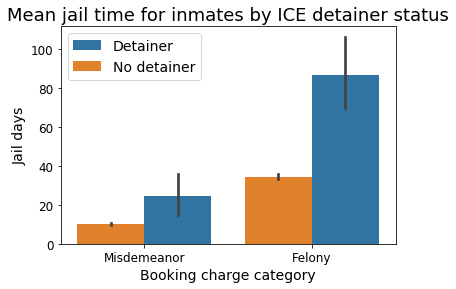

In [37]:
def barplot(data):
    
    # Create the bar plot
    ax = sns.barplot(
        x='felony_misdemeanor',
        y='time_detained',
        hue='imm_hold_text',
        hue_order=['Detainer', 'No detainer'],
        data=df)
    
    ax.legend(loc=2, fontsize=14)
    ax.set_title("Mean jail time for inmates by ICE detainer status", fontsize=18)
    ax.set_ylabel('Jail days', fontsize=14)
    ax.tick_params(axis='y', labelsize=12)
    ax.set_xlabel('Booking charge category', fontsize=14)
    ax.tick_params(axis='x', labelsize=12)
    ax.invert_xaxis()
    plt.savefig('../output/MeanJailTime.png')
    return plt, ax

barplot(table);

In [38]:
table['% increase'] = table['Detainer'] / table['No detainer'] * 100

In [39]:
table

imm_hold_text,Detainer,No detainer,% increase
felony_misdemeanor,,,
Felony,86.874001,34.546182,251.472074
Misdemeanor,24.492290,10.077993,243.027463


In [40]:
table.to_csv('../output/felony_misdemeanor.csv')

In [41]:
hold = df['imm_hold'] == 1

In [42]:
ttest = scipystats.ttest_ind(df[hold]['time_detained'], df[~hold]['time_detained'])

In [43]:
ttest

Ttest_indResult(statistic=9.860903681963814, pvalue=6.675606109161849e-23)

In [44]:
ttest.pvalue

6.675606109161849e-23

In [45]:
df[hold]['time_detained'].describe()

count    188.000000
mean      73.618133
std      108.849322
min        0.720833
25%        2.647049
50%       34.767361
75%      103.298090
max      849.235417
Name: time_detained, dtype: float64

In [46]:
df[~hold]['time_detained'].describe()

count    29125.000000
mean        26.855650
std         64.433155
min          0.002778
25%          1.070833
50%          3.154861
75%         22.957639
max       1314.554167
Name: time_detained, dtype: float64

In [47]:
hold_median = df[hold]['time_detained'].median()
no_hold_median = df[~hold]['time_detained'].median()
print(f'Median time detained, with hold: {hold_median}')
print(f'Median time detained, no hold: {no_hold_median}')

Median time detained, with hold: 34.767361111111114
Median time detained, no hold: 3.154861111111111


In [59]:
felony = df['max_seriousness'] >= 4
print(f"Average time detained, felony: {df.loc[felony, 'time_detained'].mean()}")
print(f"Median time detained, felony: {df.loc[felony, 'time_detained'].median()}")

Average time detained, felony: 34.93115589772056
Median time detained, felony: 4.052083333333333


In [61]:
hold_felony = (df['max_seriousness'] >= 4) & (df['imm_hold'] == 1)
print(f"Average time detained, felony & hold: {df.loc[hold_felony, 'time_detained'].mean()}")
print(f"Median time detained, felony & hold: {df.loc[hold_felony, 'time_detained'].median()}")

Average time detained, felony & hold: 86.87400056306306
Median time detained, felony & hold: 44.552083333333336


## Bail

In [56]:
pd.crosstab(df.paid_bail, df.imm_hold)

imm_hold,0,1
paid_bail,,
False,23363,185
True,5762,3


In [57]:
pd.crosstab(df.paid_bail, df.imm_hold, normalize='columns')*100

imm_hold,0,1
paid_bail,,
False,80.216309,98.404255
True,19.783691,1.595745


In [58]:
scipystats.chi2_contingency(pd.crosstab(df.paid_bail, df.imm_hold))

(37.96819163749581,
 7.19074542276977e-10,
 1,
 array([[23396.97403882,   151.02596118],
        [ 5728.02596118,    36.97403882]]))

In [59]:
paid_bail = df['paid_bail'] == True

# More descriptive analysis

In [60]:
# uw = ["#4b2e83", "#b7a57a"]
# sns.palplot(sns.color_palette(uw))

Bookings with immigration holds have longer detention time. Using logged time makes this clearer.

In [61]:
hold_order = ['No hold', 'Hold']

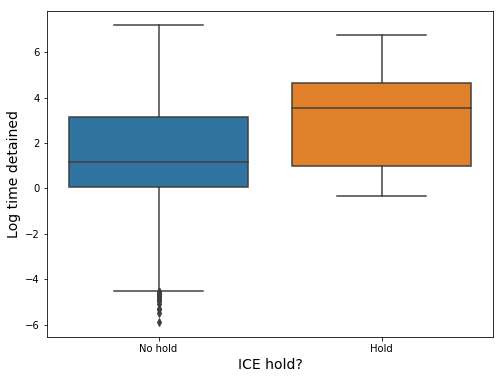

In [63]:
df['imm_hold_text'] = df['imm_hold'].replace({0: 'No hold', 1: 'Hold'})
bplot1 = sns.boxplot(data=df, y='log_time_detained', x='imm_hold_text', order=hold_order)
bplot1.set_xlabel('ICE hold?', fontsize=14)
bplot1.set_ylabel('Log time detained', fontsize=14);

# Regressions

In [64]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [65]:
data = df[['time_detained',
           'log_time_detained',
           'imm_hold',
           'charge_topcount',
           'male',
           'female',
           'white',
           'black',
           'hispanic',
           'amer_indian_alaskan',
           'asian_pacific_island',
           'unknown',
           'max_seriousness',
           'public_order',
           'felony',
           'misdemeanor',
           'drug',
           'sex',
           'property',
           'violent']]

In [66]:
data.describe().T.to_csv('descriptive_stats.csv')

In [67]:
formula = "log_time_detained ~ charge_topcount"
reg_no_detainer = smf.ols(formula = formula, data = df).fit()
reg_no_detainer.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      log_time_detained   R-squared:                       0.257
Model:                            OLS   Adj. R-squared:                  0.257
Method:                 Least Squares   F-statistic:                 1.016e+04
Date:                Fri, 28 Dec 2018   Prob (F-statistic):               0.00
Time:                        16:39:21   Log-Likelihood:                -60412.
No. Observations:               29313   AIC:                         1.208e+05
Df Residuals:                   29311   BIC:                         1.208e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           0.1855      0.016     11.278      0.000       0.153       0.218
charge_topcount     0.6500      0.006    100.790      0.000       0.637       0.663
==============================================================================
Omnibus:                      639.628   Durbin-Watson:                   1.999
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              738.347
Skew:                          -0.320   Prob(JB):                    4.68e-161
Kurtosis:                       3.440   Cond. No.                         4.12
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [68]:
formula = "log_time_detained ~ charge_topcount + max_seriousness"
reg_no_detainer = smf.ols(formula = formula, data = df).fit()
reg_no_detainer.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      log_time_detained   R-squared:                       0.301
Model:                            OLS   Adj. R-squared:                  0.301
Method:                 Least Squares   F-statistic:                     6319.
Date:                Fri, 28 Dec 2018   Prob (F-statistic):               0.00
Time:                        16:39:21   Log-Likelihood:                -59519.
No. Observations:               29313   AIC:                         1.190e+05
Df Residuals:                   29310   BIC:                         1.191e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          -1.6727      0.046    -36.243      0.000      -1.763      -1.582
charge_topcount     0.5873      0.006     91.422      0.000       0.575       0.600
max_seriousness     0.4964      0.012     42.908      0.000       0.474       0.519
==============================================================================
Omnibus:                      650.646   Durbin-Watson:                   1.998
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              743.644
Skew:                          -0.328   Prob(JB):                    3.31e-162
Kurtosis:                       3.423   Cond. No.                         20.6
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [69]:
formula = "log_time_detained ~ imm_hold + max_seriousness + charge_topcount + drug + sex + property + violent + male + black + hispanic + amer_indian_alaskan + asian_pacific_island + unknown"
reg = smf.ols(formula = formula, data = df).fit()
reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      log_time_detained   R-squared:                       0.315
Model:                            OLS   Adj. R-squared:                  0.315
Method:                 Least Squares   F-statistic:                     1038.
Date:                Fri, 28 Dec 2018   Prob (F-statistic):               0.00
Time:                        16:39:22   Log-Likelihood:                -59220.
No. Observations:               29313   AIC:                         1.185e+05
Df Residuals:                   29299   BIC:                         1.186e+05
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               -1.9139      0.050    -37.985      0.000      -2.013      -1.815
imm_hold                 1.3162      0.137      9.624      0.000       1.048       1.584
max_seriousness          0.4731      0.013     36.114      0.000       0.447       0.499
charge_topcount          0.5865      0.006     91.167      0.000       0.574       0.599
drug                     0.3036      0.037      8.311      0.000       0.232       0.375
sex                      0.5044      0.086      5.885      0.000       0.336       0.672
property                -0.1588      0.031     -5.197      0.000      -0.219      -0.099
violent                  0.1898      0.031      6.168      0.000       0.129       0.250
male                     0.3190      0.025     12.778      0.000       0.270       0.368
black                    0.1268      0.026      4.887      0.000       0.076       0.178
hispanic                -0.0843      0.040     -2.120      0.034      -0.162      -0.006
amer_indian_alaskan      0.3499      0.063      5.572      0.000       0.227       0.473
asian_pacific_island    -0.0248      0.045     -0.546      0.585      -0.114       0.064
unknown                 -0.4300      0.232     -1.851      0.064      -0.885       0.025
==============================================================================
Omnibus:                      678.167   Durbin-Watson:                   2.003
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              773.140
Skew:                          -0.338   Prob(JB):                    1.30e-168
Kurtosis:                       3.420   Cond. No.                         104.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [70]:
params = reg.params
params.name = 'coef'

In [71]:
std_err = reg.bse
std_err.name = 'std err'

In [72]:
t_vals = reg.tvalues
t_vals.name = 't'

In [73]:
p_vals = reg.pvalues
p_vals.name = 'P>|t|'

In [74]:
conf_int = reg.conf_int()
conf_int.columns = ['.025','.975']

In [75]:
def join(row):
    ''' given a row, return the concat of 0 and 1 values '''
    codes = [getattr(row, '.025'), getattr(row, '.975')]
    joined = ', '.join(["% 0.2f" % f for f in codes]) 
    return f'({joined})'

In [76]:
conf_int = conf_int.apply(join, axis=1)
conf_int.name = '95% CI'

In [77]:
coef_interpret = (np.power(np.e, reg.params) - 1)
coef_interpret.name = 'Impact'

In [78]:
imm_hold_impact = coef_interpret['imm_hold']

In [79]:
format((imm_hold_impact*100), '.0f')

'273'

In [80]:
cols = [params, std_err, t_vals, p_vals, conf_int, coef_interpret]

In [81]:
conf_int_interpret = (np.power(np.e, reg.conf_int()) - 1)
conf_int_interpret.columns = ['0.025', '0.975']

In [82]:
conf_int_interpret

,0.025,0.975
Intercept,-0.87,-0.84
imm_hold,1.85,3.88
max_seriousness,0.56,0.65
charge_topcount,0.78,0.82
drug,0.26,0.46
sex,0.40,0.96
property,-0.20,-0.09
violent,0.14,0.28
male,0.31,0.44
black,0.08,0.19


In [83]:
index = ['Intercept',
         'ICE detainer',
         'Seriousness rank',
         'Number of charges',
         'Drug offense',
         'Sex offense',
         'Property offense',
         'Violent offense',
#          'Other offense',
         'Male',
         'Black',
         'Hispanic',
         'American Indian / Alaska Native',
         'Asian / Pacific Islander',
         'Unknown race'
        ]

In [84]:
summary = pd.concat(cols, axis=1)

In [85]:
summary['index'] = index
summary.set_index('index', inplace=True)

In [86]:
summary

,coef,std err,t,P>|t|,95% CI,Impact
index,,,,,,
Intercept,-1.91,0.05,-37.99,0.00,"(-2.01, -1.82)",-0.85
ICE detainer,1.32,0.14,9.62,0.00,"( 1.05, 1.58)",2.73
Seriousness rank,0.47,0.01,36.11,0.00,"( 0.45, 0.50)",0.61
Number of charges,0.59,0.01,91.17,0.00,"( 0.57, 0.60)",0.80
Drug offense,0.30,0.04,8.31,0.00,"( 0.23, 0.38)",0.35
Sex offense,0.50,0.09,5.88,0.00,"( 0.34, 0.67)",0.66
Property offense,-0.16,0.03,-5.20,0.00,"(-0.22, -0.10)",-0.15
Violent offense,0.19,0.03,6.17,0.00,"( 0.13, 0.25)",0.21
Male,0.32,0.02,12.78,0.00,"( 0.27, 0.37)",0.38


In [87]:
summary.to_csv('../output/regression_summary.csv')


# Simple calculation of extra cost

In [88]:
cost_per_day = 126

In [89]:
df = df.copy()
df.loc[:,'approx_cost'] = df['time_detained'] * 126

In [90]:
non_detainer_mean_time = df[df['imm_hold'] == 0]['time_detained'].mean()
non_detainer_avg_cost =  non_detainer_mean_time * 126
detainer_mean_time = df[df['imm_hold'] == 1]['time_detained'].mean()
detainer_avg_cost =  detainer_mean_time * 126

In [91]:
diff = detainer_mean_time - non_detainer_mean_time
diff

46.76248348413124

In [92]:
non_detainer_avg_cost

3383.8118549356327

In [93]:
detainer_avg_cost

9275.884773936168

In [94]:
extra_cost_per_detainer = detainer_avg_cost - non_detainer_avg_cost

In [95]:
extra_cost_per_detainer

5892.072919000535

In [96]:
total_extra_cost = extra_cost_per_detainer * len(df[df['imm_hold'] == 1])

In [97]:
total_extra_cost

1107709.7087721005

# Predictions

In [98]:
log_time_detained = (reg.params['Intercept'] + 
                    (reg.params['imm_hold'] * 0) + 
                    (reg.params['charge_topcount'] * 2) +
                    (reg.params['male'] * 1) +
                    (reg.params['black'] * 0) +
                    (reg.params['hispanic'] * 1) +
                    (reg.params['amer_indian_alaskan'] * 0) +
                    (reg.params['asian_pacific_island'] * 0) +
#                     (reg.params['unknown'] * 0) +
                    (reg.params['max_seriousness'] * 4) +
#                     (reg.params['felony'] * 1) +
                    (reg.params['drug'] * 0) +
                    (reg.params['sex'] * 0) +
                    (reg.params['property'] * 0) +
                    (reg.params['violent'] * 0))
predicted_time_detained_0 = np.power(np.e, log_time_detained)
print(f'{predicted_time_detained_0}')

4.000500523717074


In [99]:
log_time_detained = (reg.conf_int()[0]['Intercept'] + 
                    (reg.conf_int()[0]['imm_hold'] * 0) + 
                    (reg.conf_int()[0]['charge_topcount'] * 2) +
                    (reg.conf_int()[0]['male'] * 1) +
                    (reg.conf_int()[0]['black'] * 0) +
                    (reg.conf_int()[0]['hispanic'] * 1) +
                    (reg.conf_int()[0]['amer_indian_alaskan'] * 0) +
                    (reg.conf_int()[0]['asian_pacific_island'] * 0) +
#                     (reg.conf_int()[0]['unknown'] * 0) +
                    (reg.conf_int()[0]['max_seriousness'] * 4) +
#                     (reg.conf_int()[0]['felony'] * 1) +
                    (reg.conf_int()[0]['drug'] * 0) +
                    (reg.conf_int()[0]['sex'] * 0) +
                    (reg.conf_int()[0]['property'] * 0) +
                    (reg.conf_int()[0]['violent'] * 0))
lower_predicted_time_detained_0 = np.power(np.e, log_time_detained)
print(f'{lower_predicted_time_detained_0}')

2.8091175954841203


In [100]:
log_time_detained = (reg.conf_int()[1]['Intercept'] + 
                    (reg.conf_int()[1]['imm_hold'] * 0) + 
                    (reg.conf_int()[1]['charge_topcount'] * 2) +
                    (reg.conf_int()[1]['male'] * 1) +
                    (reg.conf_int()[1]['black'] * 0) +
                    (reg.conf_int()[1]['hispanic'] * 1) +
                    (reg.conf_int()[1]['amer_indian_alaskan'] * 0) +
                    (reg.conf_int()[1]['asian_pacific_island'] * 0) +
#                     (reg.conf_int()[1]['unknown'] * 0) +
                    (reg.conf_int()[1]['max_seriousness'] * 4) +
#                     (reg.conf_int()[1]['felony'] * 1) +
                    (reg.conf_int()[1]['drug'] * 0) +
                    (reg.conf_int()[1]['sex'] * 0) +
                    (reg.conf_int()[1]['property'] * 0) +
                    (reg.conf_int()[1]['violent'] * 0))
higher_predicted_time_detained_0 = np.power(np.e, log_time_detained)
print(f'{higher_predicted_time_detained_0}')

5.697164286033553


In [101]:
log_time_detained = (reg.params['Intercept'] + 
                    (reg.params['imm_hold'] * 1) + 
                    (reg.params['charge_topcount'] * 2) +
                    (reg.params['male'] * 1) +
                    (reg.params['black'] * 0) +
                    (reg.params['hispanic'] * 1) +
                    (reg.params['amer_indian_alaskan'] * 0) +
                    (reg.params['asian_pacific_island'] * 0) +
#                     (reg.params['unknown'] * 0) +
                    (reg.params['max_seriousness'] * 4) +
#                     (reg.params['felony'] * 1) +
                    (reg.params['drug'] * 0) +
                    (reg.params['sex'] * 0) +
                    (reg.params['property'] * 0) +
                    (reg.params['violent'] * 0))
predicted_time_detained_1 = np.power(np.e, log_time_detained)
print(f'{predicted_time_detained_1}')

14.918509271235822


In [102]:
log_time_detained = (reg.conf_int()[0]['Intercept'] + 
                    (reg.conf_int()[0]['imm_hold'] * 1) + 
                    (reg.conf_int()[0]['charge_topcount'] * 2) +
                    (reg.conf_int()[0]['male'] * 1) +
                    (reg.conf_int()[0]['black'] * 0) +
                    (reg.conf_int()[0]['hispanic'] * 1) +
                    (reg.conf_int()[0]['amer_indian_alaskan'] * 0) +
                    (reg.conf_int()[0]['asian_pacific_island'] * 0) +
#                     (reg.conf_int()[0]['unknown'] * 0) +
                    (reg.conf_int()[0]['max_seriousness'] * 4) +
#                     (reg.conf_int()[0]['felony'] * 1) +
                    (reg.conf_int()[0]['drug'] * 0) +
                    (reg.conf_int()[0]['sex'] * 0) +
                    (reg.conf_int()[0]['property'] * 0) +
                    (reg.conf_int()[0]['violent'] * 0))
lower_predicted_time_detained_1 = np.power(np.e, log_time_detained)
print(f'{lower_predicted_time_detained_1}')

8.012451138453468


In [103]:
log_time_detained = (reg.conf_int()[1]['Intercept'] + 
                    (reg.conf_int()[1]['imm_hold'] * 1) + 
                    (reg.conf_int()[1]['charge_topcount'] * 2) +
                    (reg.conf_int()[1]['male'] * 1) +
                    (reg.conf_int()[1]['black'] * 0) +
                    (reg.conf_int()[1]['hispanic'] * 1) +
                    (reg.conf_int()[1]['amer_indian_alaskan'] * 0) +
                    (reg.conf_int()[1]['asian_pacific_island'] * 0) +
#                     (reg.conf_int()[1]['unknown'] * 0) +
                    (reg.conf_int()[1]['max_seriousness'] * 4) +
#                     (reg.conf_int()[1]['felony'] * 1) +
                    (reg.conf_int()[1]['drug'] * 0) +
                    (reg.conf_int()[1]['sex'] * 0) +
                    (reg.conf_int()[1]['property'] * 0) +
                    (reg.conf_int()[1]['violent'] * 0))
higher_predicted_time_detained_1 = np.power(np.e, log_time_detained)
print(f'{higher_predicted_time_detained_1}')

27.777007938036203


In [104]:
print(f'Predicted time multiple: {predicted_time_detained_1 / predicted_time_detained_0}\
      ({lower_predicted_time_detained_1 / lower_predicted_time_detained_0}, \
     {higher_predicted_time_detained_1 / higher_predicted_time_detained_0})')

Predicted time multiple: 3.7291606844671166      (2.852301787342089,      4.875584860020765)


In [105]:
print(predicted_time_detained_1 - predicted_time_detained_0)
print(lower_predicted_time_detained_1 - lower_predicted_time_detained_0)
print(higher_predicted_time_detained_1 - higher_predicted_time_detained_0)

10.918008747518748
5.2033335429693475
22.07984365200265


# Correlation matrix

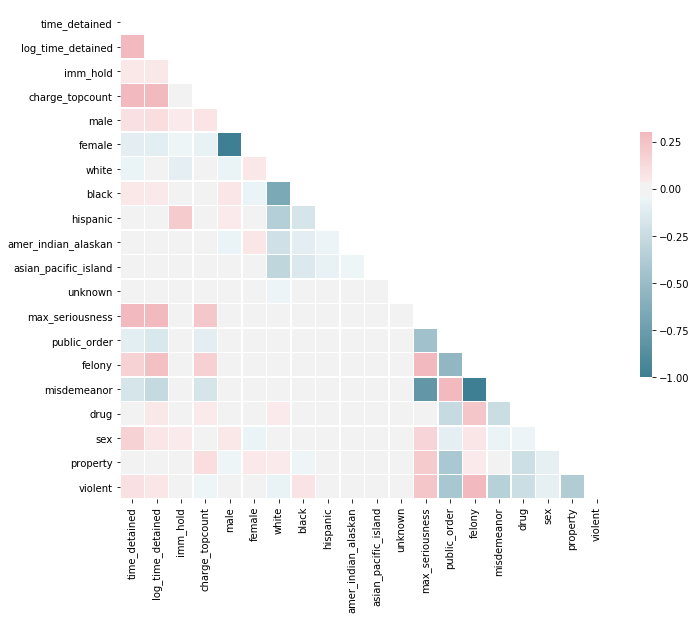

In [106]:
from string import ascii_letters
import matplotlib.pyplot as plt

corr = data.corr()

corr

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [107]:
df['time_detained'].median()

3.188194444444445

In [108]:
df['max_seriousness'].median()

4.0

In [109]:
df['max_seriousness'].mean()

3.981339337495309